# Análisis Exploratorio

### Integrantes:
Jorge Caballeros Pérez 20009

Lucía Alejandra Guzmán Dominguez 20262

Pablo Emmanuel Escobar Sandoval 20936]

Edwin Eduardo Ramirez Herrer 19946 

# Hacking the Human Vasculature

# Objetivo

El objetivo de este proyecto es segmentar las estructuras microvasculares, incluyendo capilares, arteriolas y vénulas, en imágenes histológicas de tejido renal humano sano. Tu ayuda en la automatización de esta tarea permitirá a los investigadores entender mejor cómo están organizados los vasos sanguíneos en los tejidos humanos.

### __Objetivos Secundarios:__
Diferenciar entre vasos sanguíneos y glomérulos en imágenes histológicas.
Utilizar aprendizaje semi-supervisado o auto-supervisado para aprovechar las imágenes no anotadas y mejorar la precisión de la segmentación.
Establecer si hay alguna correlación o patrón distintivo entre las características demográficas del donante (como edad, género, raza, BMI) y las estructuras vasculares en las imágenes histológicas.
Justificación:

- Mejora del Diagnóstico: La capacidad de segmentar con precisión las microestructuras vasculares en imágenes histológicas puede mejorar la calidad del diagnóstico en enfermedades renales. La identificación precisa de estas estructuras es esencial para la interpretación clínica.

- Automatización y Eficiencia: Las técnicas actuales para la identificación de estructuras en imágenes histológicas pueden ser manuales o semi-automatizadas y requieren una considerable experiencia por parte de los patólogos. Un modelo de aprendizaje automático bien entrenado puede aumentar la eficiencia y reducir la carga de trabajo.

- Aprovechamiento de Datos No Anotados: En muchos casos, se dispone de una gran cantidad de datos no anotados. Utilizar técnicas de aprendizaje semi-supervisado o auto-supervisado puede maximizar el uso de estos datos, potencialmente mejorando la precisión del modelo sin la necesidad de anotaciones manuales adicionales.

- Descubrimiento de Nuevos Patrones: Al correlacionar las características demográficas con las estructuras vasculares, podríamos descubrir patrones o características específicas asociadas con ciertas demografías, lo que podría ofrecer nuevas perspectivas en la investigación renal.

- Reducción de Falsos Positivos: Al ser capaces de distinguir entre vasos sanguíneos y glomérulos, podemos reducir los falsos positivos en el diagnóstico, lo que es esencial para garantizar tratamientos adecuados basados en el diagnóstico.

Esta investigación tiene el potencial de avanzar en el campo del diagnóstico renal y ofrecer herramientas valiosas para los patólogos y otros profesionales de la salud en su trabajo diario.

# Contexto

El correcto funcionamiento de nuestros órganos y tejidos depende de la interacción y organización de nuestras células. Actualmente, se está trabajando en el desarrollo del Marco de Coordenadas Comunes Vasculares (VCCF), que utiliza la vasculatura sanguínea del cuerpo humano como sistema de navegación principal. Sin embargo, hay lagunas en nuestro conocimiento sobre la microvasculatura que dificultan este trabajo.


# Descripción de los archivos a usar

## wsi_meta.csv
wsi_meta.csv es un archivo que contiene metadatos para las Imágenes de Diapositivas Completas (Whole Slide Images) de las cuales se extrajeron los mosaicos. El campo source_wsi identifica la Imagen de Diapositiva Completa específica.

Además, el archivo proporciona información demográfica sobre el donante del tejido, incluyendo edad, sexo, raza, altura, peso e índice de masa corporal (bmi). Esta información es crucial ya que permite a los investigadores correlacionar los hallazgos de las imágenes con las características individuales del donante. Esto puede ayudar a descubrir patrones o tendencias que podrían estar relacionadas con ciertas características demográficas.

## tile_meta.csv
tile_meta.csv es un archivo que contiene metadatos para cada imagen. La versión oculta de este archivo también contiene metadatos para los mosaicos del conjunto de prueba.

El campo source_wsi identifica la Imagen de Diapositiva Completa (WSI) de la cual se extrajo este mosaico. Los campos {i|j} representan la ubicación de la esquina superior izquierda dentro de la WSI donde se extrajo el mosaico.

El campo dataset indica a qué conjunto de datos pertenece este mosaico, como se describió anteriormente. Esta información es útil para rastrear el origen de cada mosaico y para entender mejor el contexto de cada imagen.

## Polygons.jsonl

polygons.jsonl es un archivo en formato JSONL que contiene máscaras de segmentación poligonales. Cada línea proporciona anotaciones JSON para una sola imagen con los siguientes campos:

id: Identifica la imagen correspondiente en el conjunto de entrenamiento (train/).

annotations: Una lista de anotaciones de máscaras con:

    type: Identifica el tipo de estructura anotada:
        blood_vessel: La estructura objetivo. Tu objetivo en esta competencia es predecir este tipo de máscaras en el conjunto de prueba.
        
        glomerulus: Una estructura de bola capilar en el riñón. Estas partes de las imágenes fueron excluidas de la anotación de vasos sanguíneos. Debes asegurarte de que ninguna de tus predicciones en el conjunto de prueba ocurra dentro de las estructuras de glomérulos, ya que se contarán como falsos positivos.
        
        unsure: Una estructura que los expertos anotadores no pueden distinguir con confianza como un vaso sanguíneo.


coordinates: Una lista de coordenadas de polígonos que definen la máscara de segmentación.

## {train/test}

Folders que contienen las imagenes de los tiles, cada imagen tiene un tamaño de 512x512 pixeles

# Análisis

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

## wsi_meta file

In [3]:
wsi_meta = pd.read_csv("wsi_meta.csv")

wsi_meta.head()

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


### Metadatos de las imágenes de diapositiva completa (WSIs):

- **source_wsi**: Identificador de la WSI.
- **age**: Edad del donante del tejido.
- **sex**: Sexo del donante del tejido.
- **race**: Raza del donante del tejido.
- **height**: Altura del donante del tejido (en cm).
- **weight**: Peso del donante del tejido (en kg).
- **bmi**: Índice de masa corporal del donante del tejido.

In [6]:
wsi_meta.describe()

,source_wsi,age,height,weight,bmi
count,4.000000,4.000000,4.00000,4.000000,4.00000
mean,2.500000,60.000000,165.87500,89.775000,32.05000
std,1.290994,8.906926,6.68998,35.195679,9.91514
min,1.000000,53.000000,160.00000,59.000000,23.00000
25%,1.750000,55.250000,161.72500,69.500000,25.62500
50%,2.500000,57.000000,164.15000,80.250000,29.85000
75%,3.250000,61.750000,168.30000,100.525000,36.27500
max,4.000000,73.000000,175.20000,139.600000,45.50000


## tile_meta file

In [5]:
tile_meta = pd.read_csv("tile_meta.csv")

tile_meta.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


### Metadatos de los mosaicos (tiles):

- **id**: Identificador de la imagen.
- **source_wsi**: Identifica la imagen de diapositiva completa (Whole Slide Image, WSI) de la que se extrajo este mosaico.
- **dataset**: El conjunto de datos al que pertenece este mosaico.
- **i, j**: La ubicación de la esquina superior izquierda dentro de la WSI donde se extrajo el mosaico.

In [7]:
tile_meta.describe()

,source_wsi,dataset,i,j
count,7033.000000,7033.000000,7033.000000,7033.000000
mean,8.205744,2.707806,14296.542585,23227.014930
std,4.004251,0.571724,5946.054578,10644.032931
min,1.000000,1.000000,1536.000000,2560.000000
25%,6.000000,3.000000,9728.000000,15265.000000
50%,9.000000,3.000000,13824.000000,22528.000000
75%,12.000000,3.000000,18944.000000,29656.000000
max,14.000000,3.000000,30208.000000,52753.000000


## Polygons

In [8]:
# Cargar anotaciones
with open("polygons.jsonl", 'r') as f:
    polygons = [json.loads(line) for line in f]

In [11]:
# Crear un DataFrame a partir de las anotaciones
annotations_df = pd.DataFrame(polygons)

# Extraer el tipo de cada anotación
annotations_df['annotation_type'] = annotations_df['annotations'].apply(lambda x: x[0]['type'] if x else None)

# Conteo de los diferentes tipos de anotaciones
annotation_counts = annotations_df['annotation_type'].value_counts()


In [13]:
# show first 5 rows
annotations_df.head()

,id,annotations,annotation_type
0,0006ff2aa7cd,"[{'type': 'glomerulus', 'coordinates': [[[167,...",glomerulus
1,00168d1b7522,"[{'type': 'glomerulus', 'coordinates': [[[511,...",glomerulus
2,0033bbc76b6b,"[{'type': 'blood_vessel', 'coordinates': [[[16...",blood_vessel
3,003504460b3a,"[{'type': 'blood_vessel', 'coordinates': [[[40...",blood_vessel
4,004daf1cbe75,"[{'type': 'blood_vessel', 'coordinates': [[[14...",blood_vessel


In [16]:
# show anoatation json
sample_annotation = annotations_df['annotations'][0]
print(json.dumps(sample_annotation, indent=2))


[
  {
    "type": "glomerulus",
    "coordinates": [
      [
        [
          167,
          249
        ],
        [
          166,
          249
        ],
        [
          165,
          249
        ],
        [
          164,
          249
        ],
        [
          163,
          249
        ],
        [
          162,
          249
        ],
        [
          161,
          249
        ],
        [
          160,
          249
        ],
        [
          159,
          249
        ],
        [
          158,
          249
        ],
        [
          157,
          249
        ],
        [
          156,
          249
        ],
        [
          155,
          249
        ],
        [
          154,
          249
        ],
        [
          153,
          249
        ],
        [
          152,
          249
        ],
        [
          151,
          249
        ],
        [
          150,
          249
        ],
        [
          149,
          249


In [18]:
print(dict(annotation_counts))

{'blood_vessel': 1372, 'glomerulus': 150, 'unsure': 111}


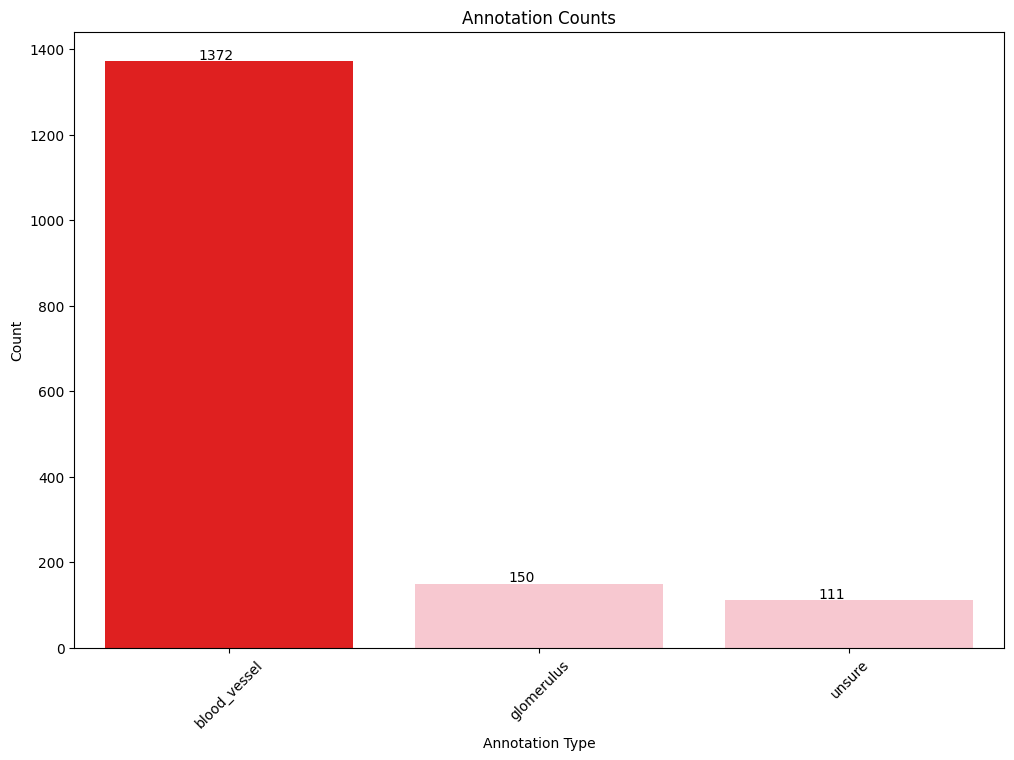

In [32]:
# graph annotation counts
plt.figure(figsize=(12, 8))
cols = ['pink' if (x < max(annotation_counts.values)) else 'red' for x in annotation_counts.values]
sns.barplot(x=annotation_counts.index, y=annotation_counts.values, palette=cols)

# add values to the top of the bars
for i, v in enumerate(annotation_counts.values):
    plt.text(i - 0.1, v + 5, str(v))


plt.title('Annotation Counts')
plt.ylabel('Count')
plt.xlabel('Annotation Type')
plt.xticks(rotation=45)
plt.show()


En el análisis del conjunto de datos, se ha observado que el valor más común es blood_vessel. Esto significa que la mayoría de las anotaciones en las imágenes corresponden a vasos sanguíneos. Este es un hallazgo relevante, ya que los vasos sanguíneos son la estructura objetivo de este estudio.

# Train file

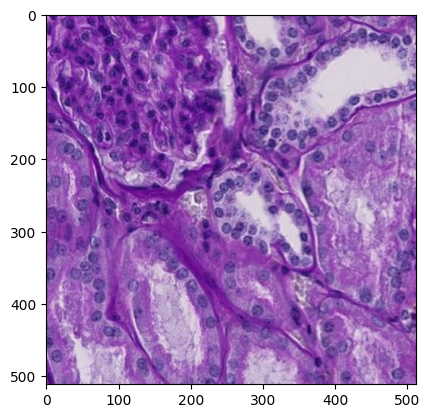

In [58]:
# load image 
from PIL import Image

testFileId = "0006ff2aa7cd"
filePath = f"./train/class1/{testFileId}.tif"
img = Image.open(filePath)
plt.imshow(img)


Lo que podemos ver es una muestra del tipo de imagenes que tenemos que analizar, la cual es un tejido de riñon. Ahora procederemos a obtener los datos de esta imagen para crear la mascara y mostrar que anotaciones tiene.

In [51]:
jsonObj = pd.read_json('./polygons.jsonl', lines=True)

In [52]:
# convert the json object to a dataframe
polygons_df = pd.DataFrame(jsonObj)

In [59]:
image_info =polygons_df.loc[polygons_df['id'] == testFileId]


In [61]:
annotations = list(image_info['annotations'])[0]

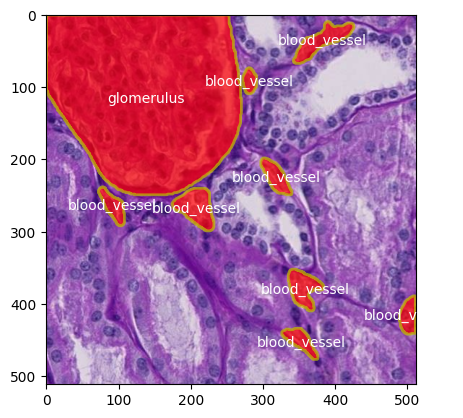

In [67]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PIL import Image, ImageDraw

# Load your image
path = f"./train/class1/{testFileId}.tif"
im = Image.open(path)

# Create a Matplotlib figure
fig, ax = plt.subplots()

# Display the image using Matplotlib
ax.imshow(im)

# Loop through the annotations
for annotation in annotations:
    typeOf = annotation["type"]

    # Get the coordinates of the polygon
    polygonCoordinates = annotation["coordinates"]

    # Loop through the polygon coordinates and draw each polygon with the type label
    for polygon in polygonCoordinates:
        poly = Polygon(polygon, closed=True, edgecolor='y', facecolor='r', fill=True, alpha=0.7, linewidth=2, linestyle='-', joinstyle='round', capstyle='round')
        ax.add_patch(poly)

        # Add the type label within the polygon
        x, y = zip(*polygon)
        x_center = sum(x) / len(x)
        y_center = sum(y) / len(y)
        ax.text(x_center, y_center, typeOf, color='white',alpha=1, ha='center', va='center')

# Show the image with polygons and type labels
plt.show()
